In [6]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# 1. Anslut till databasen du skapade tidigare
conn = sqlite3.connect("matkassen_data.db")

# 2. Läs in den färdigtvättade tabellen (processed_data)
# Nu har du alla kolumner som 'feat_sentiment_index' och 'kassatyp' redo!
df = pd.read_sql("SELECT * FROM processed_data", conn)

# 3. Stäng anslutningen
conn.close()

C:\Users\johan\AppData\Local\Temp\ipykernel_37152\2102554340.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_kpi.index, y=sentiment_kpi.values, palette="viridis")


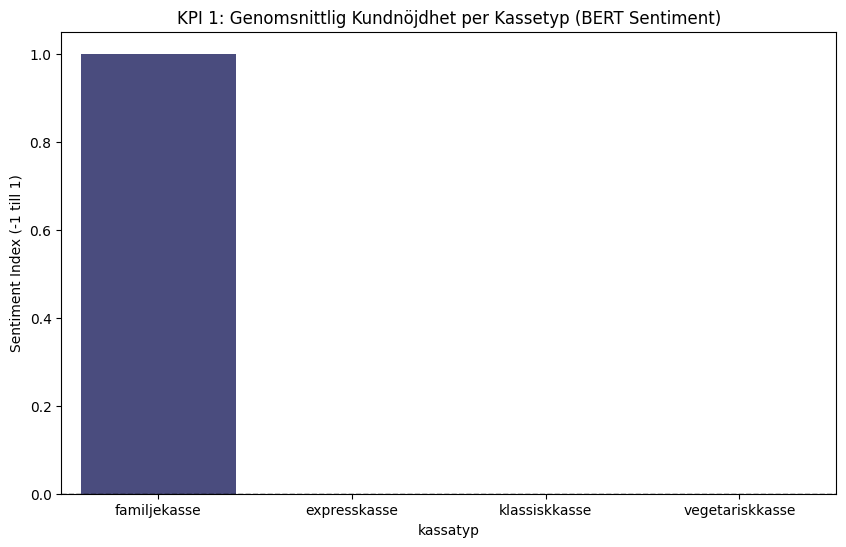

kassatyp
familjekasse       1.0
expresskasse       0.0
klassiskkasse      0.0
vegetariskkasse    0.0
Name: feat_sentiment_index, dtype: float64


In [16]:
# Beräkna genomsnittligt sentiment-index per kassetyp
# 1.0 är max positivt, -1.0 är max negativt
sentiment_kpi = df.groupby('kassatyp')['feat_sentiment_index'].mean().sort_values(ascending=False)

# Visualisering
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_kpi.index, y=sentiment_kpi.values, palette="viridis")
plt.axhline(0, color='black', linestyle='--', linewidth=1) # Neutral-linje
plt.title("KPI 1: Genomsnittlig Kundnöjdhet per Kassetyp (BERT Sentiment)")
plt.ylabel("Sentiment Index (-1 till 1)")
plt.show()

print(sentiment_kpi)

C:\Users\johan\AppData\Local\Temp\ipykernel_37152\1554149159.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_kpi.index, y=churn_kpi.values, palette="magma")


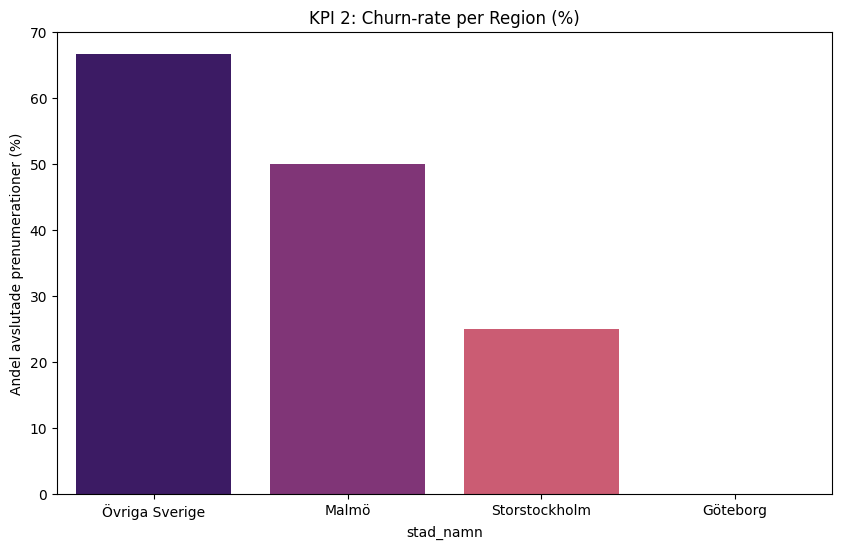

stad_namn
Övriga Sverige    66.666667
Malmö             50.000000
Storstockholm     25.000000
Göteborg           0.000000
Name: har_avslutat, dtype: float64


In [17]:
# Beräkna andel som avslutat prenumerationen per stad (gör om till procent)
churn_kpi = df.groupby('stad_namn')['har_avslutat'].mean().sort_values(ascending=False) * 100

# Visualisering
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_kpi.index, y=churn_kpi.values, palette="magma")
plt.title("KPI 2: Churn-rate per Region (%)")
plt.ylabel("Andel avslutade prenumerationer (%)")
plt.show()

print(churn_kpi)

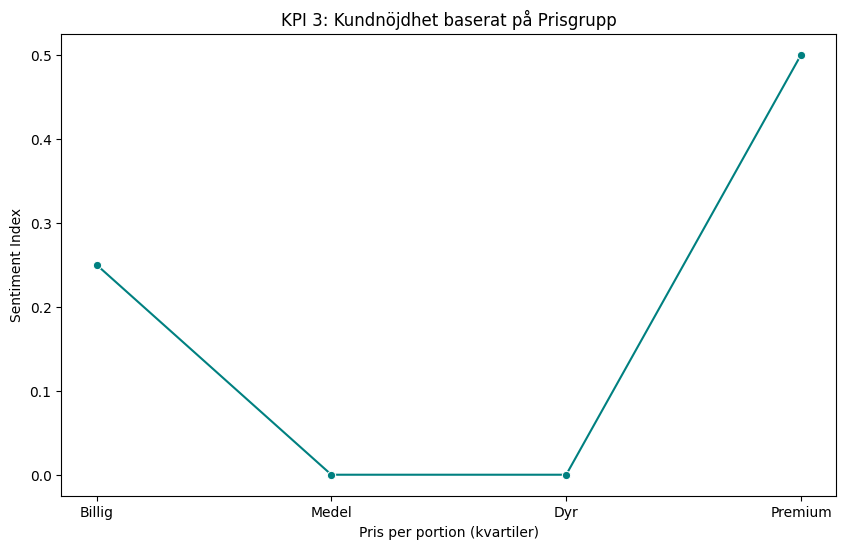

In [18]:
# Dela upp priset i grupper (bins) för att se mönster
df['pris_grupp'] = pd.qcut(df['pris_per_portion'], q=4, labels=['Billig', 'Medel', 'Dyr', 'Premium'])
price_sentiment = df.groupby('pris_grupp')['feat_sentiment_index'].mean()

# Visualisering
plt.figure(figsize=(10, 6))
sns.lineplot(x=price_sentiment.index, y=price_sentiment.values, marker='o', color='teal')
plt.title("KPI 3: Kundnöjdhet baserat på Prisgrupp")
plt.ylabel("Sentiment Index")
plt.xlabel("Pris per portion (kvartiler)")
plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_37152\723970729.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lojalitet_kpi.index, y=lojalitet_kpi.values, palette="spring")


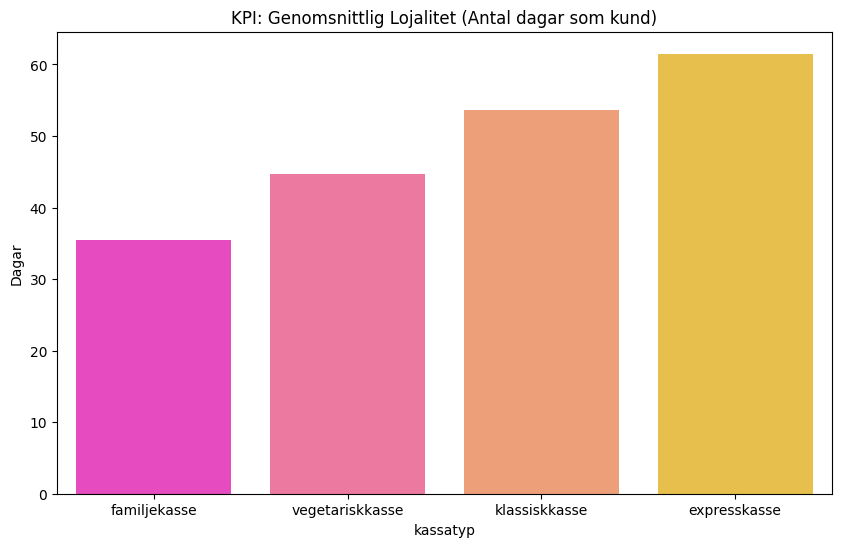

In [19]:
# Beräkna genomsnittlig 'kundalder' per kassetyp
lojalitet_kpi = df.groupby('kassatyp')['feat_kundalder_dagar'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=lojalitet_kpi.index, y=lojalitet_kpi.values, palette="spring")
plt.title("KPI: Genomsnittlig Lojalitet (Antal dagar som kund)")
plt.ylabel("Dagar")
plt.show()

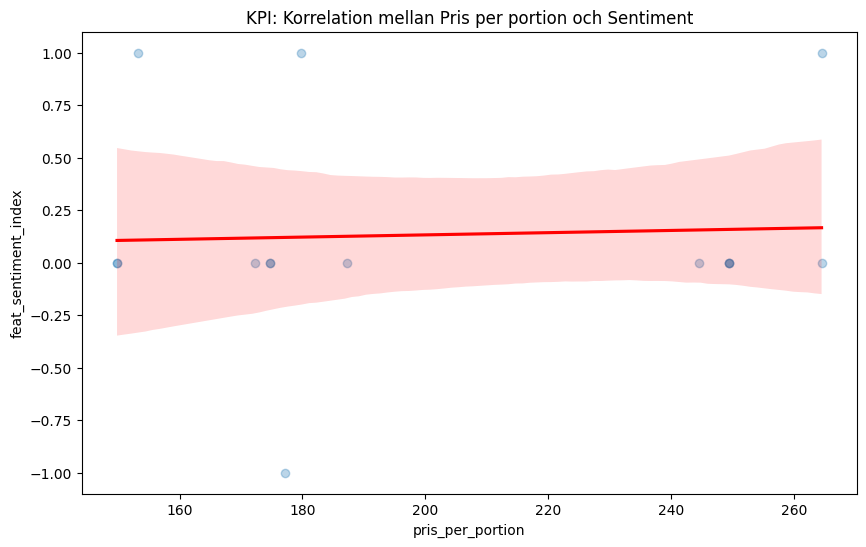

In [20]:
#kundnöjdhet vs pris per portion, typ ingen skillnad
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='pris_per_portion', y='feat_sentiment_index', 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("KPI: Korrelation mellan Pris per portion och Sentiment")
plt.show()

C:\Users\johan\AppData\Local\Temp\ipykernel_37152\2129111236.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='stad_namn', y='omdome_langd', palette="Set3")


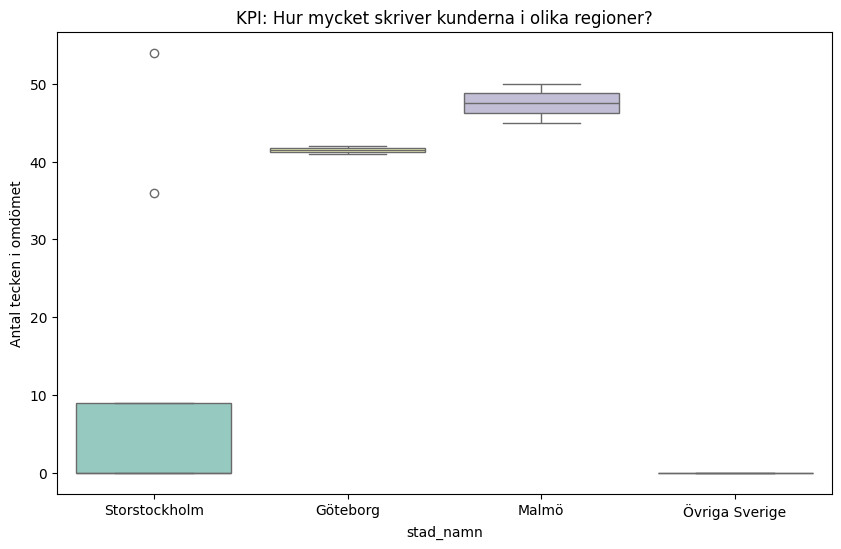

In [21]:
# egagemang KPI: Hur mycket skriver kunderna i olika regioner?
engagemang_kpi = df.groupby('stad_namn')['omdome_langd'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='stad_namn', y='omdome_langd', palette="Set3")
plt.title("KPI: Hur mycket skriver kunderna i olika regioner?")
plt.ylabel("Antal tecken i omdömet")
plt.show()

--- KPI: Engagemang (längd omdöme) vs. Churn ---
har_avslutat
0    16.9
1    19.8
Name: omdome_langd, dtype: float64


C:\Users\johan\AppData\Local\Temp\ipykernel_37152\608259282.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=engagement_churn_kpi.index, y=engagement_churn_kpi.values, palette="Pastel1")


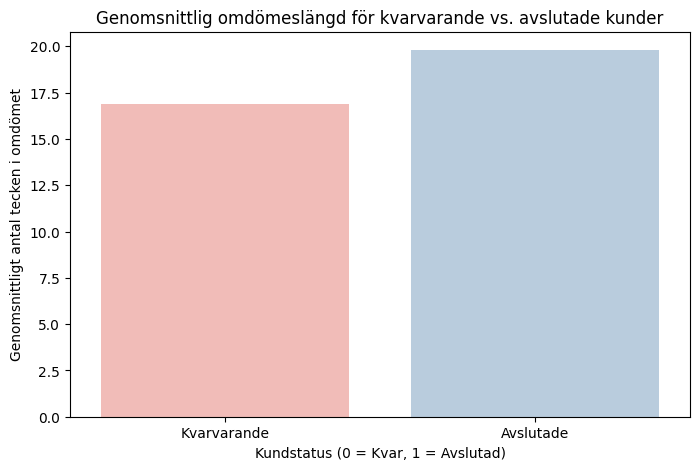

In [22]:
# Hämta datan från din DataFrame (som du läste in från databasen)
# Du behöver inte ladda in den igen, bara använd 'df'

# Beräkna genomsnittlig omdömeslängd baserat på churn-status
# har_avslutat == 0 betyder kvarvarande kunder
# har_avslutat == 1 betyder kunder som har avslutat
engagement_churn_kpi = df.groupby('har_avslutat')['omdome_langd'].mean()

print("--- KPI: Engagemang (längd omdöme) vs. Churn ---")
print(engagement_churn_kpi)

# Visualisering
plt.figure(figsize=(8, 5))
sns.barplot(x=engagement_churn_kpi.index, y=engagement_churn_kpi.values, palette="Pastel1")
plt.title("Genomsnittlig omdömeslängd för kvarvarande vs. avslutade kunder")
plt.xlabel("Kundstatus (0 = Kvar, 1 = Avslutad)")
plt.ylabel("Genomsnittligt antal tecken i omdömet")
plt.xticks(ticks=[0, 1], labels=["Kvarvarande", "Avslutade"])
plt.show()